In [ ]:
#!pip install ISLP

Results: The KNN model provides the best performance for fraud detection

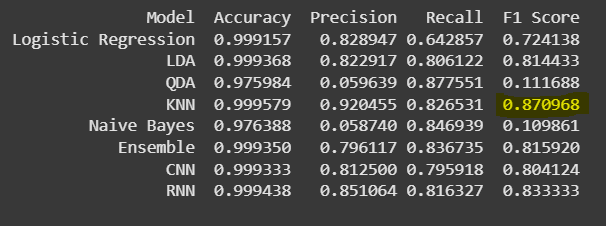

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import mode


In [ ]:
# Load dataset
file_path = "creditcard.csv"
credit_data = pd.read_csv(file_path)

# Inspect data
print(credit_data.head())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
# Check for missing values
print(credit_data.isnull().sum().sum())  # No missing values expected

0


In [ ]:
print(credit_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
print(credit_data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.804747e-12 -6.644481e-13 -5.733476e-13  7.602684e-13   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.290382e-13  6.119060e-14  3.241792e-14 -5.131360e-13 -7.735175e-13   
std    1.380247e+00  1.332271e+00  1.23709

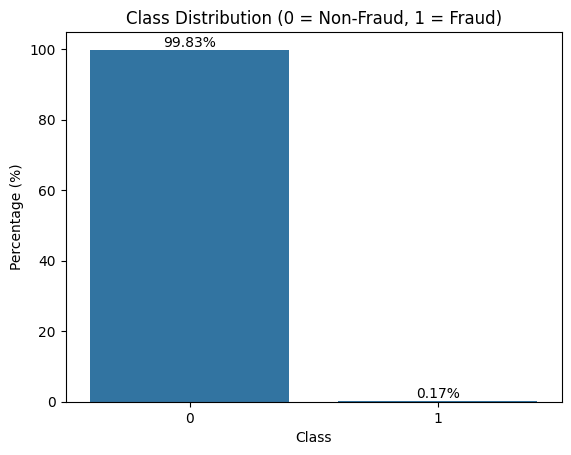

In [ ]:
# Change the scaling Show as % for y
# Calculate the percentage distribution of each class
class_distribution = credit_data['Class'].value_counts(normalize=True) * 100

# Plotting the percentage distribution
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')

# Adding percentage values on the bars
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 0.1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
# Defining features and labels
X = credit_data.drop(['Class', 'Time'], axis=1)  # Dropping 'Time' as it's not relevant
y = credit_data['Class']

Evaluation Matrix:

> Precision: Out of all samples predicted as fraud (1), how many were truly fraud.

> Recall: Out of all actual fraud cases, how many were correctly detected.

> F1-Score: Harmonic mean of precision and recall, balancing both.

> Accuracy: The overall percentage of correct predictions.



In [ ]:
# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42, stratify=y)
# The stratify=y ensures the class distribution of y (fraud/not fraud) is preserved in the train and test sets.

# Standardize features if Stdev is not 1
scaler = StandardScaler()   # The features are scaled using StandardScaler(), which scales data to have zero mean and unit variance.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# fit_transform() is applied to the training data, and transform() to the testing data.

# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_logreg = log_reg.predict(X_test_scaled)

# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))


Confusion Matrix:
[[56851    13]
 [   35    63]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9991573329588147


In [ ]:
print(sum(y_test))
print(len(y_test))
sum(y_test)/len(y_test)

98
56962


0.0017204452090867595

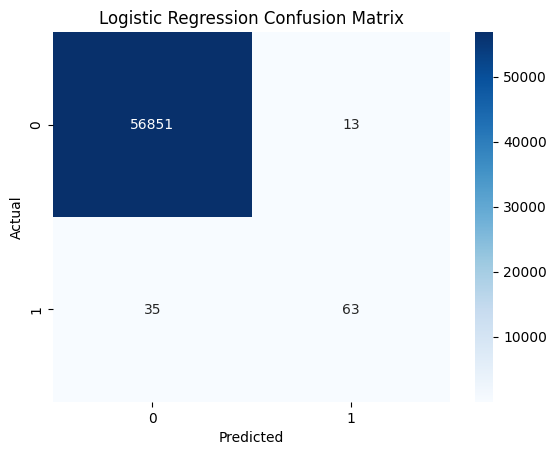

In [ ]:
# Confusion Matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# use logistic reg chapter 4 equation table 4.1 and 4.2
# Getting coefficients, std errors, z-scores, and p-values using statsmodels
X_train_sm = sm.add_constant(X_train_scaled)  # Adding constant for intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

#MLE Maximum Likelihood estimation
# statistical method used to estimate the parameters of a model by maximizing the likelihood function,
# which measures how well the model explains the observed data.

Optimization terminated successfully.
         Current function value: 0.003796
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               227845
Model:                          Logit   Df Residuals:                   227815
Method:                           MLE   Df Model:                           29
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.7017
Time:                        21:31:11   Log-Likelihood:                -864.98
converged:                       True   LL-Null:                       -2899.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8634      0.188    -47.107      0.000      -9.232      -8.495
x1             0.1396      0

📌 Coefficient Table:

coef (Coefficient): The effect size of each feature. Positive values indicate that an increase in the feature value increases the probability of the positive class, while negative values decrease it.

std err (Standard Error): Indicates the precision of the coefficient estimate. Smaller values suggest more precise estimates.

z: The test statistic, calculated as coef / std err. Higher absolute values indicate stronger evidence against the null hypothesis.

P>|z| (p-value): Indicates statistical significance. Values less than 0.05 generally imply that the predictor is significant.

[0.025 0.975]: The 95% confidence interval for the coefficient. If it crosses zero, the coefficient is not statistically significant.

In [ ]:
# LDA
lda = LDA()
lda.fit(X_train_scaled, y_train) # train LDA model
y_pred_lda = lda.predict(X_test_scaled) #Make prediction

print('LDA Report:')
# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))
print("Classification Report:")
print(classification_report(y_test, y_pred_lda))
print("Accuracy:", accuracy_score(y_test, y_pred_lda))

LDA Report:
Confusion Matrix:
[[56847    17]
 [   19    79]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993679997191109


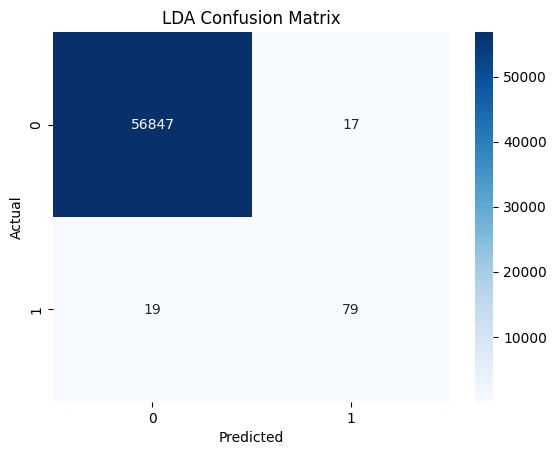

In [ ]:
# Confusion Matrix for LDA
conf_matrix = confusion_matrix(y_test, y_pred_lda)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('LDA Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# QDA
qda = QDA()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)

# Evaluate model
print('QDA Report:')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))
print("Classification Report:")
print(classification_report(y_test, y_pred_qda))
print("Accuracy:", accuracy_score(y_test,y_pred_qda))

QDA Report:
Confusion Matrix:
[[55508  1356]
 [   12    86]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9759839893262174


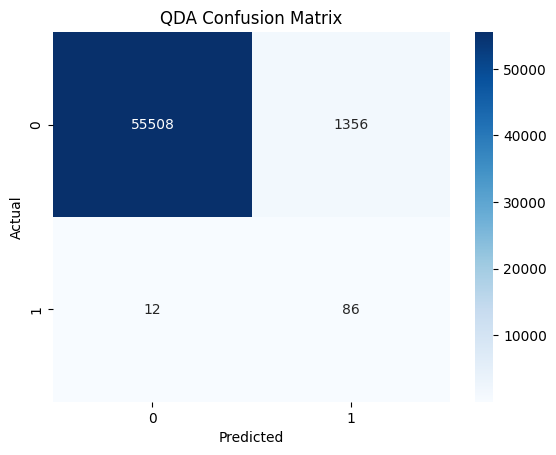

In [ ]:
# Confusion Matrix for QDA
conf_matrix = confusion_matrix(y_test, y_pred_qda)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('QDA Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
k_values = range(2, 10)
metrics_list = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Get the full classification report as a dict
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract metrics for class '1'
    accuracy = accuracy_score(y_test, y_pred)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    avg = (precision + recall + f1) / 3

    metrics_list.append({
        'k': k,
        'accuracy': accuracy,
        'precision_class_1': precision,
        'recall_class_1': recall,
        'f1_score_class_1': f1,
        'avg_metric_class_1': avg
    })

# Create DataFrame to review all results
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# Select best k based on highest average metric for class 1
best_row = metrics_df.loc[metrics_df['avg_metric_class_1'].idxmax()]
best_k = int(best_row['k'])

print(f'\nBest k: {best_k} based on best average of accuracy, precision, recall, and F1-score for class 1.')
print(best_row)

# Final model evaluation
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)
y_pred_knn =  final_knn.predict(X_test_scaled)

print('\nFinal KNN Report:')
print("Confusion Matrix:")
print(confusion_matrix(y_test,  y_pred_knn))
print("Classification Report:")
print(classification_report(y_test,  y_pred_knn))
print("Accuracy:", accuracy_score(y_test,y_pred_knn))


   k  accuracy  precision_class_1  recall_class_1  f1_score_class_1  \
0  2  0.999561           0.939759        0.795918          0.861878   
1  3  0.999579           0.920455        0.826531          0.870968   
2  4  0.999544           0.939024        0.785714          0.855556   
3  5  0.999561           0.929412        0.806122          0.863388   
4  6  0.999473           0.925000        0.755102          0.831461   
5  7  0.999456           0.903614        0.765306          0.828729   
6  8  0.999421           0.911392        0.734694          0.813559   
7  9  0.999403           0.900000        0.734694          0.808989   

   avg_metric_class_1  
0            0.865852  
1            0.872651  
2            0.860098  
3            0.866307  
4            0.837188  
5            0.832550  
6            0.819882  
7            0.814561  

Best k: 3 based on best average of accuracy, precision, recall, and F1-score for class 1.
k                     3.000000
accuracy              

In [ ]:

print("Classification Report:")
print(classification_report(y_test,  y_pred_knn))
print("Accuracy:", accuracy_score(y_test,y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.83      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995786664794073


In [ ]:
1-0.9995786664794073

0.0004213335205927038

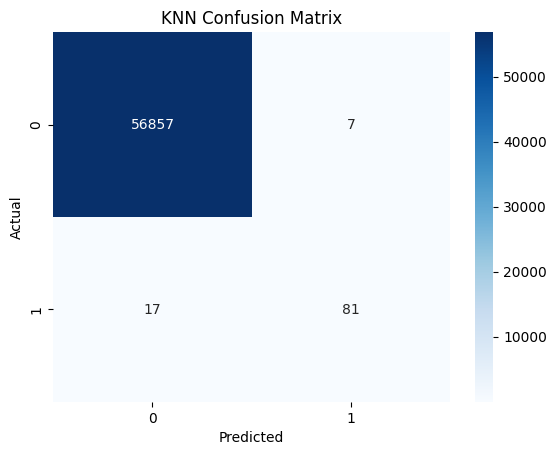

In [ ]:
# Confusion Matrix for KNN
conf_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

# Evaluate model
print('Naive Bayes Report:')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test,y_pred_nb))


Naive Bayes Report:
Confusion Matrix:
[[55534  1330]
 [   15    83]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.85      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9763877672834521


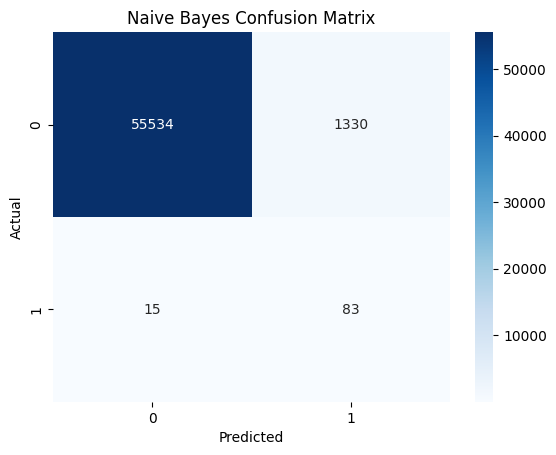

In [ ]:
# Confusion Matrix for NB
conf_matrix = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Ensemble Method: Soft Voting Classifier
log_reg = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=k)
lda = LDA()
qda = QDA()


# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('nb', nb),
    ('knn', knn),
    ('lda', lda),
    ('qda', qda)

], voting='soft')
# Train the ensemble model
voting_clf.fit(X_train_scaled, y_train)
# Make predictions
y_pred_ensemble = voting_clf.predict(X_test_scaled)
# Evaluate the ensemble model
print("Ensemble Model Evaluation:")
print(classification_report(y_test, y_pred_ensemble))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))

Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993504441557529


In [ ]:
# Model Evaluation
# Store all models' predictions and evaluate them
models = {
    "Logistic Regression": y_pred_logreg,
    "LDA": y_pred_lda,
    "QDA": y_pred_qda,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "Ensemble": y_pred_ensemble
}

results = [] # List to store evaluation results for each model
for name, y_pred in models.items():
    # Evaluate each model by calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    results.append([name, accuracy, precision, recall, f1_score])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
final = print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.999157   0.828947 0.642857  0.724138
                LDA  0.999368   0.822917 0.806122  0.814433
                QDA  0.975984   0.059639 0.877551  0.111688
                KNN  0.999579   0.920455 0.826531  0.870968
        Naive Bayes  0.976388   0.058740 0.846939  0.109861
           Ensemble  0.999350   0.796117 0.836735  0.815920


        Deep Learning Method



*   CNN is great for identifying spatial relationships in the input features, making it well-suited for fraud detection with structured data.

        CNN Model: It applies a convolutional layer to the data followed by a fully connected layer, using the ReLU activation and sigmoid for binary classification.

*   RNN explores if there's a time-series or sequence pattern in the transactions, even though this dataset may not naturally represent time steps.

        RNN Model: It uses a recurrent neural network to process sequential data, followed by a fully connected layer and a sigmoid activation for the final prediction.


1. Data Preprocessing


*   Tensor Conversion: Input features (`X_train_scaled`, `X_test_scaled`) and labels (`y_train`, `y_test`) are converted to PyTorch tensors using `torch.tensor()` for compatibility with neural network models.
*   Batching: Both CNN and RNN models use `DataLoader` to efficiently handle data batching. Batches are shuffled during training for better generalization.


2. CNN Model:
Defining the CNN model: The FraudCNN class defines a simple CNN with:

    A 1D convolutional layer (conv1) with 16 output channels, kernel size 3, and padding 1.

    A ReLU activation function.

    A fully connected layer (fc) that reduces the features after the convolution to a single output.

    A sigmoid activation function to output probabilities.

Training the CNN: The CNN is trained using the Adam optimizer and binary cross-entropy loss (BCELoss), iterating over the training data for 10 epochs. For each batch, the gradients are zeroed, the model makes predictions, and the loss is calculated and used for backpropagation to update the model's parameters.

> An epoch in machine learning refers to one complete pass through the entire training dataset during the model training process. In each epoch, the model’s parameters (weights) are adjusted based on the computed errors (or loss) to minimize the difference between predicted and actual outputs. Typically, training a model involves running several epochs to allow the model to learn from the data and improve its performance over time. The number of epochs is a hyperparameter that can be set before training, and more epochs usually lead to better learning, up to a point where overfitting might occur if training continues for too long.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Convert data to PyTorch tensors
def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_torch = to_tensor(X_train_scaled)
X_test_torch = to_tensor(X_test_scaled)
y_train_torch = to_tensor(y_train.values)
y_test_torch = to_tensor(y_test.values)

# Define utility function for evaluation
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze().round()
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred))
        print("F1 Score:", f1_score(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# CNN: Feature pattern learning (Ch. 4 style)


# Prepare CNN input tensors (add channel dimension)
X_train_cnn = X_train_torch.unsqueeze(1)
X_test_cnn = X_test_torch.unsqueeze(1)

# DataLoaders
cnn_train = DataLoader(TensorDataset(X_train_cnn, y_train_torch), batch_size=64, shuffle=True)
cnn_test = DataLoader(TensorDataset(X_test_cnn, y_test_torch), batch_size=64)

# CNN Model
class FraudCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(16 * 29, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

cnn_model = FraudCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop (Ch. 5 & 7 style)
for epoch in range(10):
    cnn_model.train()
    for X_batch, y_batch in cnn_train:
        optimizer.zero_grad()
        y_pred = cnn_model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"[CNN] Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("\nCNN Evaluation:")
evaluate_model(cnn_model, X_test_cnn, y_test_torch)

[CNN] Epoch 1, Loss: 0.0004
[CNN] Epoch 2, Loss: 0.0000
[CNN] Epoch 3, Loss: 0.0000
[CNN] Epoch 4, Loss: 0.0002
[CNN] Epoch 5, Loss: 0.0000
[CNN] Epoch 6, Loss: 0.0002
[CNN] Epoch 7, Loss: 0.0000
[CNN] Epoch 8, Loss: 0.0006
[CNN] Epoch 9, Loss: 0.0000
[CNN] Epoch 10, Loss: 0.0001

CNN Evaluation:
Accuracy: 0.9993328885923949
Precision: 0.8125
Recall: 0.7959183673469388
F1 Score: 0.8041237113402062
Confusion Matrix:
 [[56846    18]
 [   20    78]]


> The CNN model achieved a very high accuracy of 99.93%, indicating it correctly classified most samples in the dataset. However, the fluctuating loss values across epochs suggest some instability in the training process, possibly due to overfitting or an unsuitable learning rate. While the high accuracy is promising, it’s essential to consider other metrics, like precision and recall, to ensure the model effectively identifies the minority class (fraud).

 While the model perfectly predicted the majority class (non-fraud) with 100% accuracy, its performance on the minority class (fraud) showed lower values, with precision of 0.81 and recall of 0.80.



3. RNN Model:
  Defining the RNN model: The FraudRNN class defines an RNN with:

    An RNN layer (rnn) with a hidden size of 64.

    A fully connected layer (fc) that converts the RNN's output into a single prediction.

    A sigmoid activation function for binary classification.

    Training the RNN: Similar to the CNN model, the RNN is trained using the Adam optimizer and binary cross-entropy loss, iterating over the training data for 10 epochs.

In [ ]:
# RNN: Sequential modeling (Ch. 6 style)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Prepare RNN input (as time sequence of one step)
X_train_rnn = X_train_torch.unsqueeze(1)
X_test_rnn = X_test_torch.unsqueeze(1)

rnn_train = DataLoader(TensorDataset(X_train_rnn, y_train_torch), batch_size=64, shuffle=True)
rnn_test = DataLoader(TensorDataset(X_test_rnn, y_test_torch), batch_size=64)

class FraudRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=29, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, h_n = self.rnn(x)
        x = self.dropout(h_n[-1])  # get last hidden state properly
        x = self.fc(x)
        return self.sigmoid(x).squeeze(-1)  # ensure shape is (batch_size,)

rnn_model = FraudRNN()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)

for epoch in range(10):
    rnn_model.train()
    for X_batch, y_batch in rnn_train:
        optimizer_rnn.zero_grad()
        y_pred = rnn_model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_rnn.step()
    print(f"[RNN] Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("\nRNN Evaluation:")
evaluate_model(rnn_model, X_test_rnn, y_test_torch)

[RNN] Epoch 1, Loss: 0.0002
[RNN] Epoch 2, Loss: 0.0001
[RNN] Epoch 3, Loss: 0.0002
[RNN] Epoch 4, Loss: 0.0132
[RNN] Epoch 5, Loss: 0.0003
[RNN] Epoch 6, Loss: 0.0000
[RNN] Epoch 7, Loss: 0.0001
[RNN] Epoch 8, Loss: 0.0001
[RNN] Epoch 9, Loss: 0.0013
[RNN] Epoch 10, Loss: 0.0003

RNN Evaluation:
Accuracy: 0.9994382219725431
Precision: 0.851063829787234
Recall: 0.8163265306122449
F1 Score: 0.8333333333333334
Confusion Matrix:
 [[56850    14]
 [   18    80]]


The RNN model achieved an impressive overall accuracy of 99.94%, demonstrating strong performance on the majority class (non-fraud). While it perfectly predicted the non-fraud class with 100% accuracy, the fraud class (class 1) had precision(0.85) and recall (0.82), indicating the model's struggle with the minority class.

In [ ]:
# Model Evaluation
# Store all models' predictions and evaluate them
models = {
    "Logistic Regression": y_pred_logreg,
    "LDA": y_pred_lda,
    "QDA": y_pred_qda,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "Ensemble": y_pred_ensemble,
    "CNN": cnn_model(X_test_cnn).detach().squeeze().round(),
    "RNN": rnn_model(X_test_rnn).detach().squeeze().round()
}

results = [] # List to store evaluation results for each model
for name, y_pred in models.items():
    # Evaluate each model by calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    results.append([name, accuracy, precision, recall, f1_score])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
final = print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.999157   0.828947 0.642857  0.724138
                LDA  0.999368   0.822917 0.806122  0.814433
                QDA  0.975984   0.059639 0.877551  0.111688
                KNN  0.999579   0.920455 0.826531  0.870968
        Naive Bayes  0.976388   0.058740 0.846939  0.109861
           Ensemble  0.999350   0.796117 0.836735  0.815920
                CNN  0.999333   0.812500 0.795918  0.804124
                RNN  0.999438   0.851064 0.816327  0.833333




> The KNN model provides the best performance for fraud detection, achieving the highest recall (0.8265) and a strong F1 score (0.871), demonstrating its ability to correctly identify a majority of fraudulent cases while maintaining a good balance between precision and recall. Although other models like LDA and RNN also show strong performance, KNN outperforms them with a higher recall and F1 score, making it the most suitable model for detecting fraud in this dataset. This suggests that KNN can effectively capture fraud cases while minimizing false positives, making it a reliable choice for this task.


